## IMPORT PACKAGE

In [1]:
import os, sys, re
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install scikit-learn pandas matplotlib seaborn sdv xgboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
#Import necessary packages

import pandas as pd
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.sampling import Condition
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
import openpyxl

In [4]:
dfs = pd.read_excel('~/E-commerce_KPI_analysis_dataset.xlsx', sheet_name= 'data')

In [5]:
dfs.head(4)

,Row ID,Order ID,Order Date,Customer ID,Segment,City,State,Country,Country latitude,Country longitude,Region,Market,Subcategory,Category,Product,Quantity,Sales,Discount,Profit
0,46682,IZ-2012-LW699061-40911,2020-01-03,LW-699061,Corporate,Mosul,Ninawa,Iraq,33.223191,43.679291,Western Asia,Asia Pacific,"bath oils, bubbles and soaks",Body care,Head & Shoulders Classic Clean Shampoo,20,600,0.0,300.0
1,10124,US-2012-BT1130518-40912,2020-01-04,BT-1130518,Self-Employed,Pilar,Alagoas,Brazil,-14.235004,-51.925280,South America,LATAM,"bath oils, bubbles and soaks",Body care,Kiehl's Ultra Facial Overnight Hydrating Masque,2,40,0.6,-4.0
2,9067,MX-2012-AW1093031-40912,2020-01-04,AW-1093031,Self-Employed,Santiago de Cuba,Santiago de Cuba,Cuba,21.521757,-77.781167,Caribbean,LATAM,"bath oils, bubbles and soaks",Body care,Golden Vine Bracelet,1,151,0.0,75.5
3,130,MX-2012-BT1130531-40912,2020-01-04,BT-1130531,Self-Employed,Manzanillo,Granma,Cuba,21.521757,-77.781167,Caribbean,LATAM,"bath oils, bubbles and soaks",Body care,Kiehl's Crème de Corps Smoothing Oil-to-Foam B...,4,40,0.0,20.0


## EDA

In [6]:
#Data Shape
dfs.shape

(51290, 19)

In [7]:
#data types
dfs.dtypes

Row ID                        int64
Order ID                     object
Order Date           datetime64[ns]
Customer ID                  object
Segment                      object
City                         object
State                        object
Country                      object
Country latitude            float64
Country longitude           float64
Region                       object
Market                       object
Subcategory                  object
Category                     object
Product                      object
Quantity                      int64
Sales                         int64
Discount                    float64
Profit                      float64
dtype: object

In [8]:
#Data Describe
dfs.describe()

,Row ID,Order Date,Country latitude,Country longitude,Quantity,Sales,Discount,Profit
count,51290.00000,51290,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,25645.50000,2022-05-11 21:26:49.155780608,24.506298,-4.585665,5.415832,127.074946,0.142908,20.772346
min,1.00000,2020-01-01 00:00:00,-40.900557,-106.346771,1.000000,2.000000,0.000000,-1746.000000
25%,12823.25000,2021-06-19 00:00:00,12.879721,-95.712891,2.000000,25.000000,0.000000,0.000000
50%,25645.50000,2022-07-08 00:00:00,35.861660,2.213749,4.000000,56.000000,0.000000,7.200000
75%,38467.75000,2023-05-22 00:00:00,38.963745,43.679291,7.000000,132.000000,0.200000,25.000000
max,51290.00000,2023-12-31 00:00:00,61.924110,174.885971,20.000000,3940.000000,0.850000,1820.000000
std,14806.29199,NaN,24.119393,80.298692,4.908234,236.074764,0.212280,83.582680


In [9]:
#Fine N/A values
print(dfs.isnull().sum())

Row ID               0
Order ID             0
Order Date           0
Customer ID          0
Segment              0
City                 0
State                0
Country              0
Country latitude     0
Country longitude    0
Region               0
Market               0
Subcategory          0
Category             0
Product              0
Quantity             0
Sales                0
Discount             0
Profit               0
dtype: int64


### Numeric column

In [10]:
numeric_columns = dfs.select_dtypes(include=['number'])
numeric_columns = numeric_columns.drop(columns='Row ID', errors='ignore')

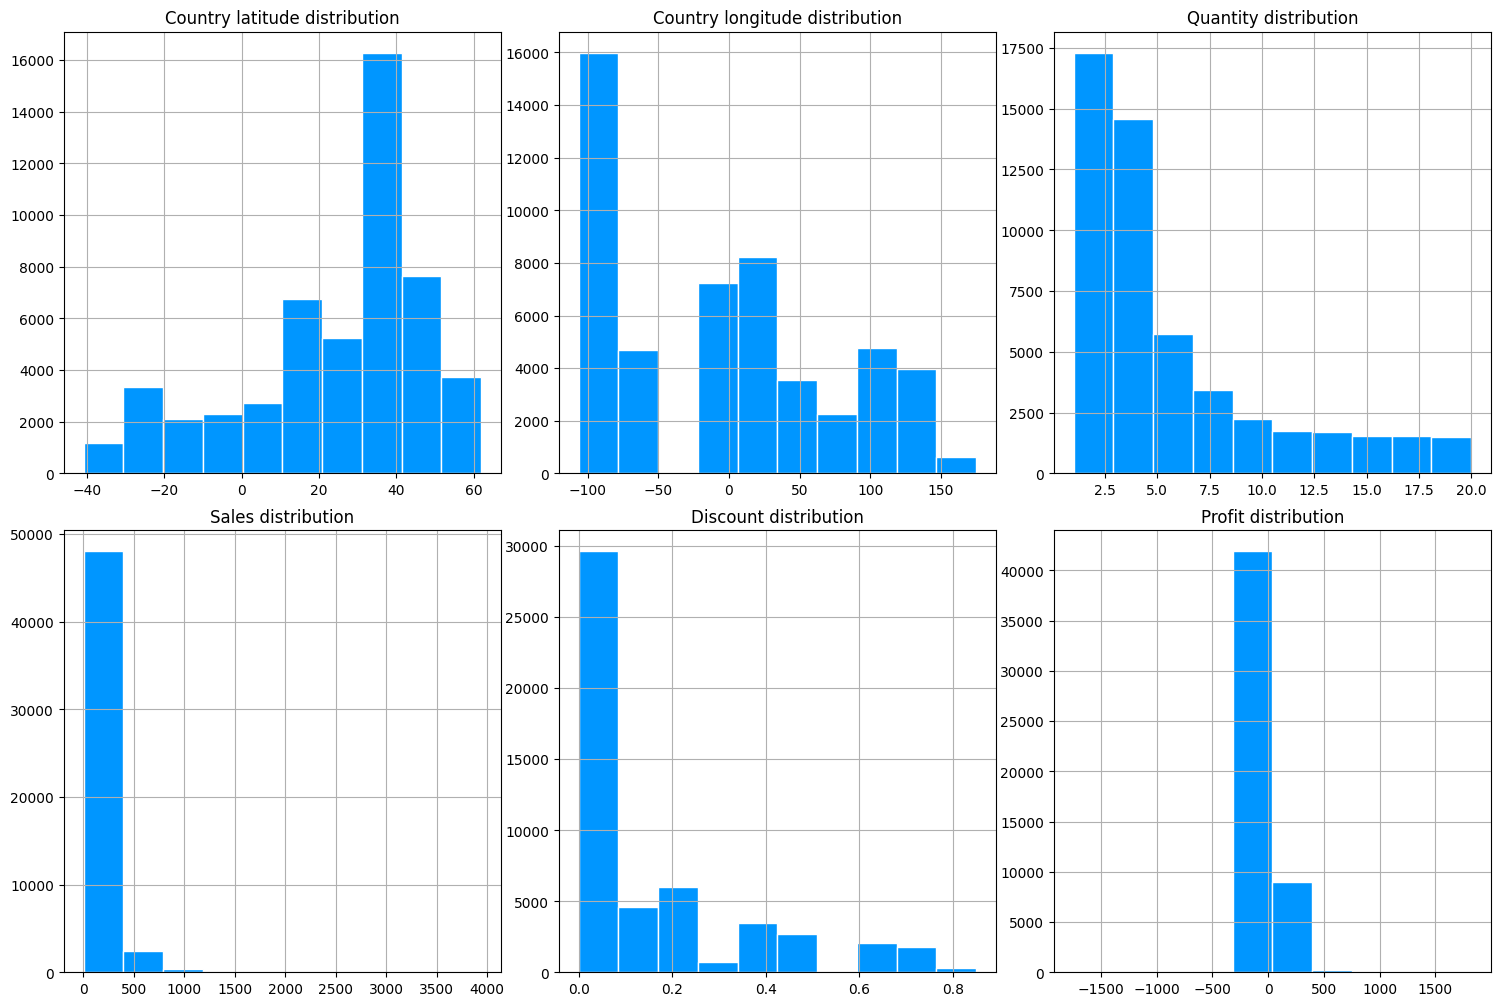

In [11]:
# Distribution of numeric features
# Initialize an 11x3 chart
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.tight_layout(h_pad=2)

# Flatten the axes array (makes it easier to iterate over)
axes = axes.flatten()

# Loop through each column and plot a histogram
for i, column in enumerate(numeric_columns):

    # Add the histogram
    dfs[column].hist(ax=axes[i], # Define on which ax we're working on
                    edgecolor='white', # Color of the border
                    color='#0096FF' # Color of the bins
                   )

    # Add title and axis label
    axes[i].set_title(f'{column} distribution')





# Show the plot
plt.show()

### Object column

In [12]:
object_columns = dfs.select_dtypes(include=['object'])
object_columns = object_columns.drop(columns=['Order ID', 'Customer ID', 'Product'], errors='ignore')

In [13]:
# Initialize counts_dict using dictionary comprehension
counts_dict = {column: {} for column in object_columns}

In [14]:
print(dfs.columns)

Index(['Row ID', 'Order ID', 'Order Date', 'Customer ID', 'Segment', 'City',
       'State', 'Country', 'Country latitude', 'Country longitude', 'Region',
       'Market', 'Subcategory', 'Category', 'Product', 'Quantity', 'Sales',
       'Discount', 'Profit'],
      dtype='object')


In [15]:
print(object_columns.columns)

Index(['Segment', 'City', 'State', 'Country', 'Region', 'Market',
       'Subcategory', 'Category'],
      dtype='object')


In [43]:
# Remove keys in counts_dict with more than 20 distinct values
keys_to_remove = [key for key, value in counts_dict.items() if len(value) > 20]

# Remove the keys from counts_dict
for key in keys_to_remove:
    del counts_dict[key]

Segment
Market
Subcategory
Category


In [49]:
object_columns_less_than_20_value = dfs[['Segment', 'Market', 'Subcategory', 'Category']]

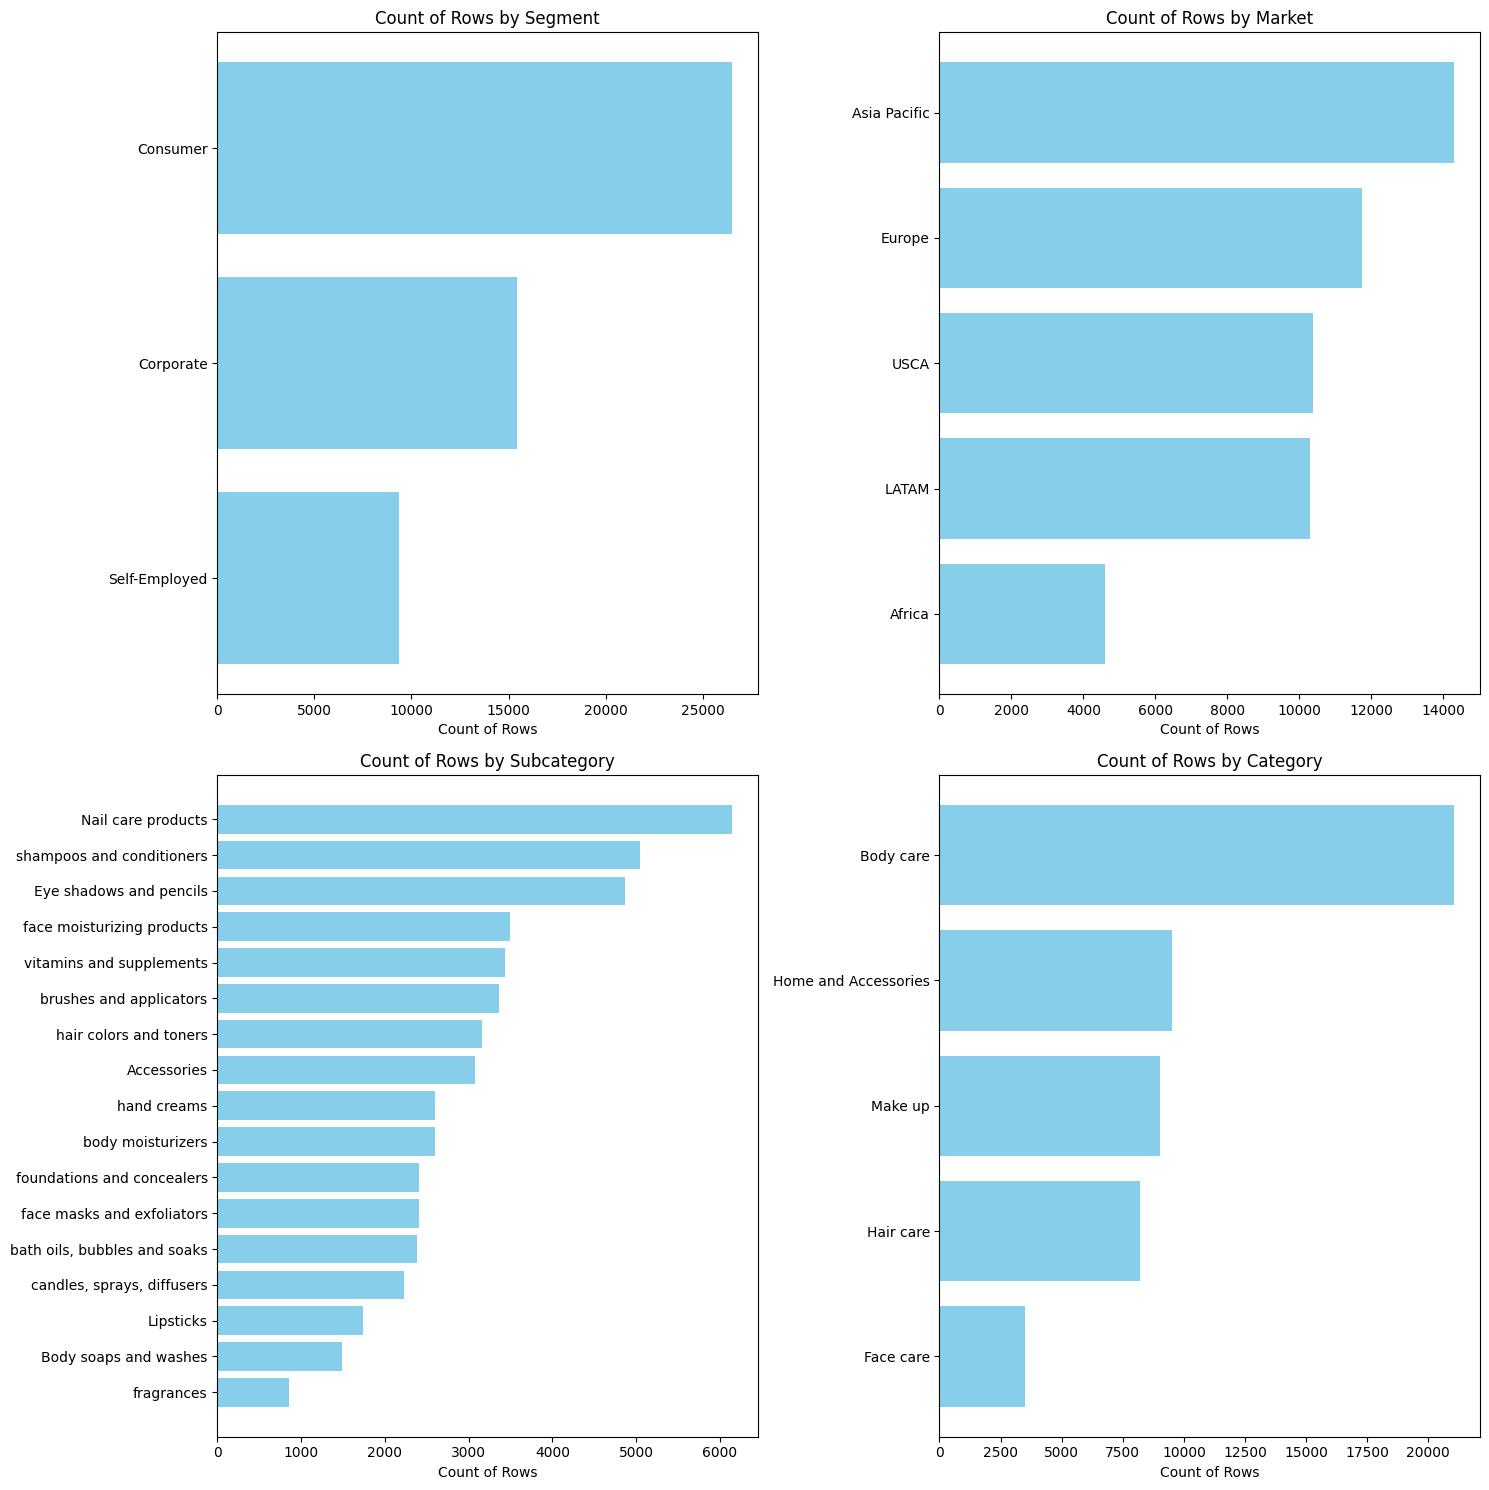

In [55]:
# Create a figure for the horizontal bar charts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

# Create horizontal bar charts using a for loop
for i, column in enumerate(object_columns_less_than_20_value):
    # Get counts and categories for the current column
    categories = list(counts_dict[column].keys())
    counts = list(counts_dict[column].values())
    
    # Sort categories and counts by descending order of counts
    sorted_pairs = sorted(zip(counts, categories), reverse=True)
    counts, categories = zip(*sorted_pairs)  # Unzip sorted pairs back into counts and categories
    
    # Convert the linear index to row and column indices
    row, col = divmod(i, 2)
    
    # Plotting on the corresponding axis
    axes[row, col].barh(categories[::-1], counts[::-1], color='skyblue')  # Categories with highest counts on top
    axes[row, col].set_xlabel('Count of Rows')
    axes[row, col].set_title(f'Count of Rows by {column.capitalize()}')

# Remove any empty subplots
for ax in axes.flat[len(object_columns):]:
    ax.set_visible(False)

# Show the chart
plt.tight_layout()
plt.show()

### Datetime column

In [103]:
dfs_order_date_analysis = dfs.copy()

In [104]:
dfs_order_date_analysis.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Customer ID', 'Segment', 'City',
       'State', 'Country', 'Country latitude', 'Country longitude', 'Region',
       'Market', 'Subcategory', 'Category', 'Product', 'Quantity', 'Sales',
       'Discount', 'Profit'],
      dtype='object')

In [105]:
dfs_order_date_analysis.dtypes

Row ID                        int64
Order ID                     object
Order Date           datetime64[ns]
Customer ID                  object
Segment                      object
City                         object
State                        object
Country                      object
Country latitude            float64
Country longitude           float64
Region                       object
Market                       object
Subcategory                  object
Category                     object
Product                      object
Quantity                      int64
Sales                         int64
Discount                    float64
Profit                      float64
dtype: object

In [106]:
# Setting the 'Datetime' column as the index of the DataFrame
dfs_order_date_analysis = dfs_order_date_analysis.set_index('Order Date')

# Ensuring that the index is of datetime type
dfs_order_date_analysis.index = pd.to_datetime(dfs_order_date_analysis.index)

# Generating descriptive statistics of the DataFrame
dfs_order_date_analysis.describe()

,Row ID,Country latitude,Country longitude,Quantity,Sales,Discount,Profit
count,51290.00000,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,25645.50000,24.506298,-4.585665,5.415832,127.074946,0.142908,20.772346
std,14806.29199,24.119393,80.298692,4.908234,236.074764,0.212280,83.582680
min,1.00000,-40.900557,-106.346771,1.000000,2.000000,0.000000,-1746.000000
25%,12823.25000,12.879721,-95.712891,2.000000,25.000000,0.000000,0.000000
50%,25645.50000,35.861660,2.213749,4.000000,56.000000,0.000000,7.200000
75%,38467.75000,38.963745,43.679291,7.000000,132.000000,0.200000,25.000000
max,51290.00000,61.924110,174.885971,20.000000,3940.000000,0.850000,1820.000000


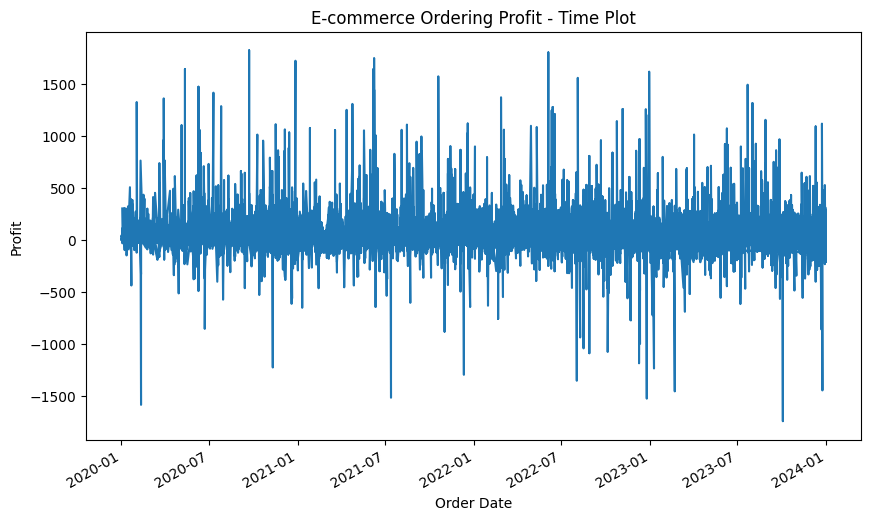

In [107]:
# Plotting time series
plt.figure(figsize=(10,6))
dfs_order_date_analysis['Profit'].plot(title='E-commerce Ordering Profit - Time Plot')
plt.ylabel('Profit')
plt.xlabel('Order Date')
plt.show()

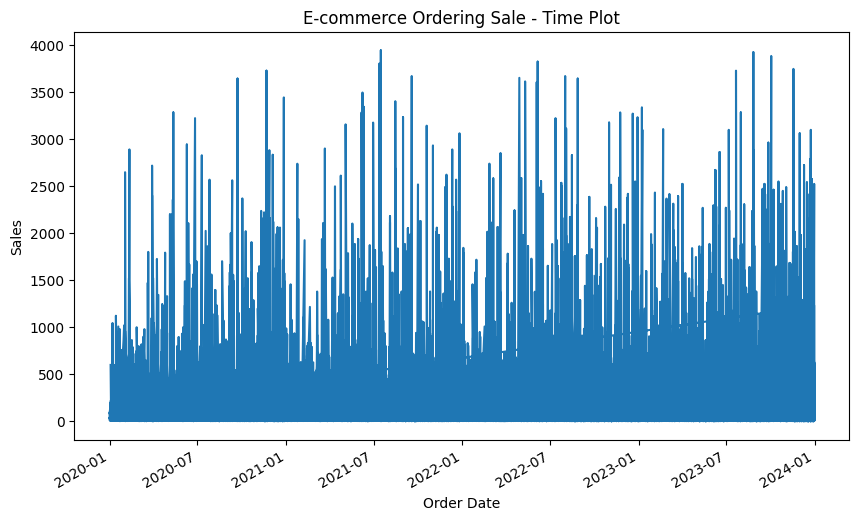

In [108]:
# Plotting time series
plt.figure(figsize=(10,6))
dfs_order_date_analysis['Sales'].plot(title='E-commerce Ordering Sale - Time Plot')
plt.ylabel('Sales')
plt.xlabel('Order Date')
plt.show()

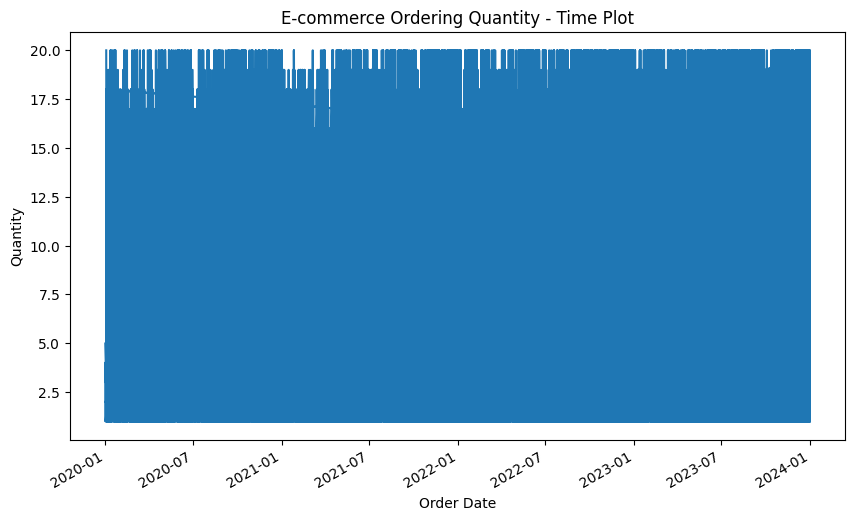

In [109]:
# Plotting time series
plt.figure(figsize=(10,6))
dfs_order_date_analysis['Quantity'].plot(title='E-commerce Ordering Quantity - Time Plot')
plt.ylabel('Quantity')
plt.xlabel('Order Date')
plt.show()

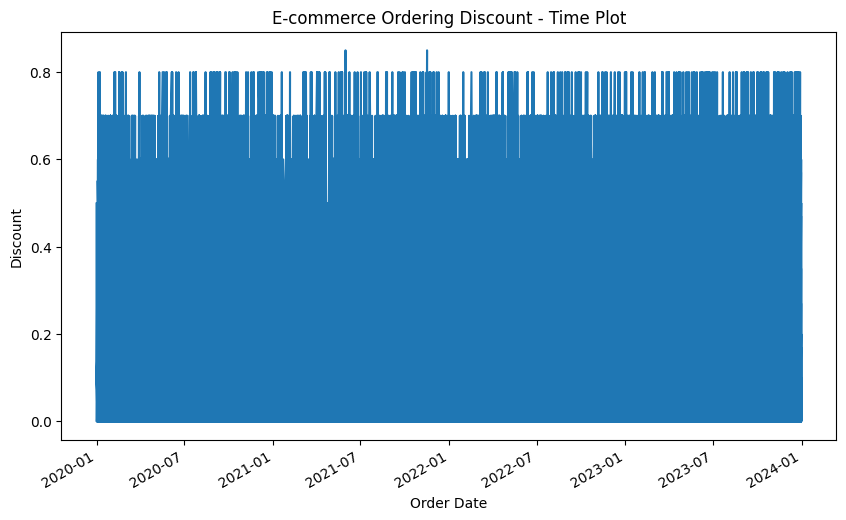

In [110]:
# Plotting time series
plt.figure(figsize=(10,6))
dfs_order_date_analysis['Discount'].plot(title='E-commerce Ordering Discount - Time Plot')
plt.ylabel('Discount')
plt.xlabel('Order Date')
plt.show()

In [111]:
# Extracting time-related features
dfs_order_date_analysis['year'] = dfs_order_date_analysis.index.year
dfs_order_date_analysis['month'] = dfs_order_date_analysis.index.month
dfs_order_date_analysis.reset_index(inplace=True)
dfs_order_date_analysis['week'] = dfs_order_date_analysis['Order Date'].dt.isocalendar().week
dfs_order_date_analysis['hour'] = dfs_order_date_analysis['Order Date'].dt.hour
dfs_order_date_analysis['day'] = dfs_order_date_analysis['Order Date'].dt.dayofweek
dfs_order_date_analysis['day_str'] = dfs_order_date_analysis['Order Date'].dt.strftime('%a')
dfs_order_date_analysis['year_month'] = dfs_order_date_analysis['Order Date'].dt.strftime('%Y_%m')
dfs_order_date_analysis.set_index('Order Date', inplace=True)

In [112]:
dfs_order_date_analysis.head()

,Row ID,Order ID,Customer ID,Segment,City,State,Country,Country latitude,Country longitude,Region,...,Sales,Discount,Profit,year,month,week,hour,day,day_str,year_month
Order Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,46682,IZ-2012-LW699061-40911,LW-699061,Corporate,Mosul,Ninawa,Iraq,33.223191,43.679291,Western Asia,...,600,0.0,300.0,2020,1,1,0,4,Fri,2020_01
2020-01-04,10124,US-2012-BT1130518-40912,BT-1130518,Self-Employed,Pilar,Alagoas,Brazil,-14.235004,-51.925280,South America,...,40,0.6,-4.0,2020,1,1,0,5,Sat,2020_01
2020-01-04,9067,MX-2012-AW1093031-40912,AW-1093031,Self-Employed,Santiago de Cuba,Santiago de Cuba,Cuba,21.521757,-77.781167,Caribbean,...,151,0.0,75.5,2020,1,1,0,5,Sat,2020_01
2020-01-04,130,MX-2012-BT1130531-40912,BT-1130531,Self-Employed,Manzanillo,Granma,Cuba,21.521757,-77.781167,Caribbean,...,40,0.0,20.0,2020,1,1,0,5,Sat,2020_01
2020-01-06,24072,IN-2012-KM1666027-40914,KM-1666027,Consumer,Huadian,Jilin,China,35.861660,104.195397,Eastern Asia,...,11,0.0,5.5,2020,1,2,0,0,Mon,2020_01


In [113]:
time_analysis_df = dfs_order_date_analysis.copy()

In [116]:
time_analysis_df['year'].value_counts()

year
2023    17531
2022    13799
2021    10962
2020     8998
Name: count, dtype: int64

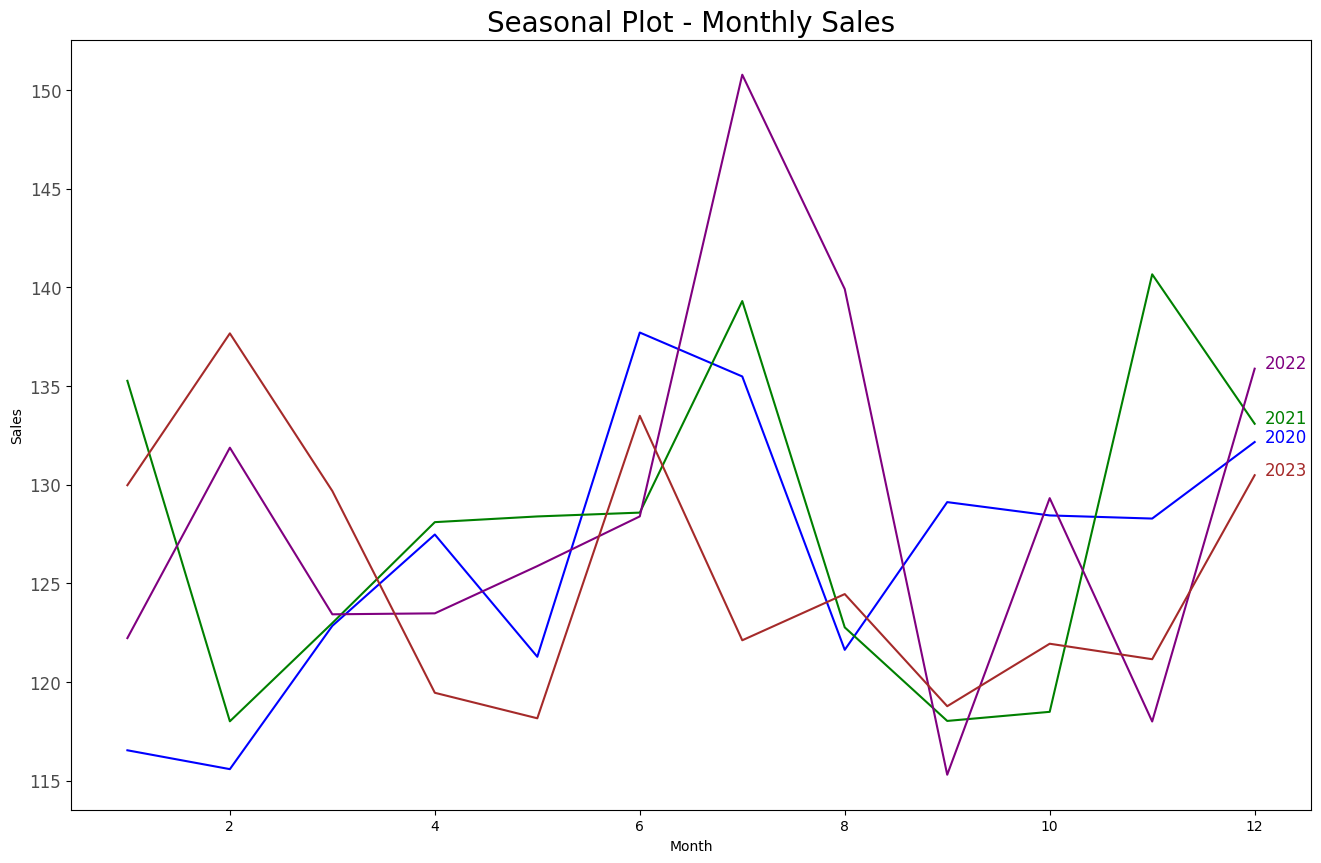

In [120]:
# Defining colors palette
np.random.seed(42)
df_plot = time_analysis_df[['month', 'year', 'Sales']].dropna().groupby(['month', 'year']).mean()[['Sales']].reset_index()
years = df_plot['year'].unique()
colors = ['blue', 'green', 'purple', 'brown']

# Plotting
plt.figure(figsize=(16,10))
for i, y in enumerate(years):
    if i < len(colors):  # Ensuring we don't exceed the number of available colors
        plt.plot('month', 'Sales', data=df_plot[df_plot['year'] == y], color=colors[i], label=y)
        if y == 2018:
            plt.text(df_plot.loc[df_plot.year==y, :].shape[0]+0.3, df_plot.loc[df_plot.year==y, 'Sales'][-1:].values[0], y, fontsize=12, color=colors[i])
        else:
            plt.text(df_plot.loc[df_plot.year==y, :].shape[0]+0.1, df_plot.loc[df_plot.year==y, 'Sales'][-1:].values[0], y, fontsize=12, color=colors[i])

# Setting labels and titles
plt.gca().set(ylabel= 'Sales', xlabel = 'Month')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot - Monthly Sales", fontsize=20)
plt.ylabel('Sales')
plt.xlabel('Month')
plt.show()

In [133]:
import matplotlib.cm as cm

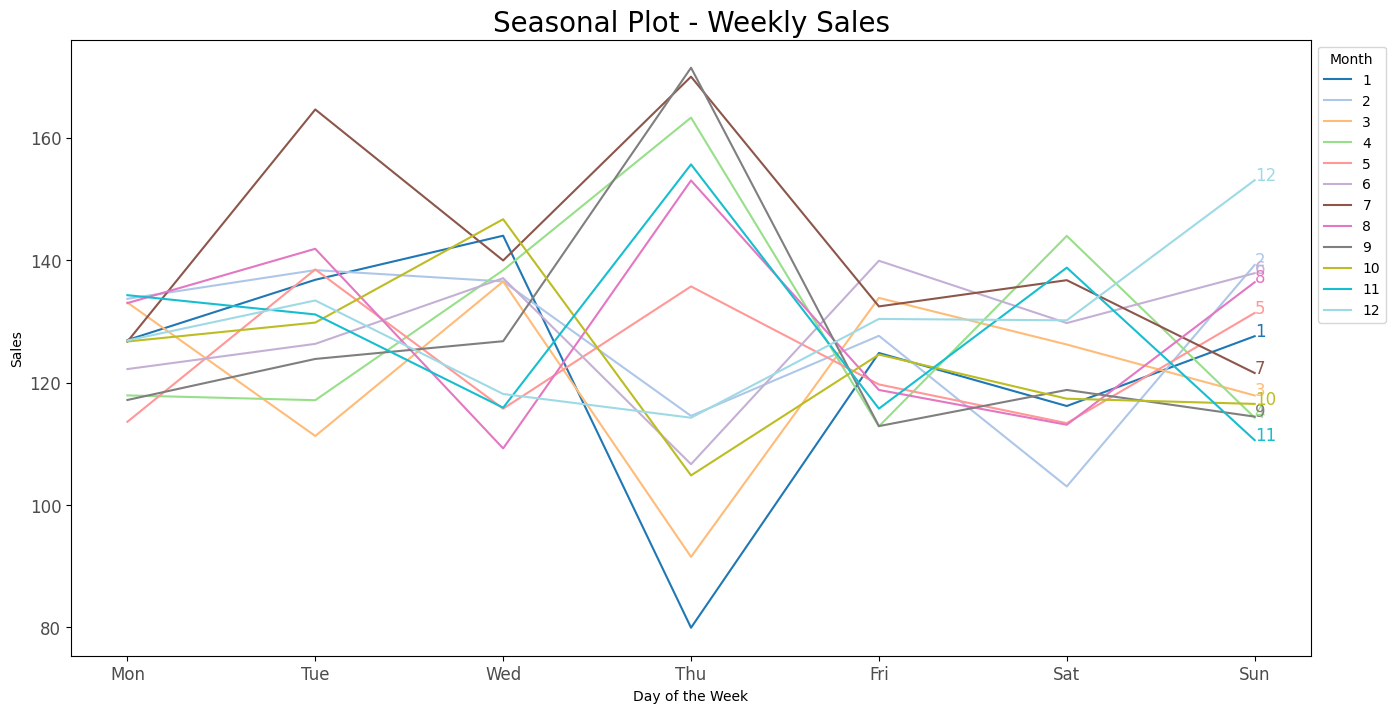

In [142]:
import matplotlib.pyplot as plt
import numpy as np

# Preparing the data
np.random.seed(42)
df_plot = time_analysis_df[['month', 'day_str', 'Sales', 'day']].dropna()
df_plot = df_plot.groupby(['day_str', 'month', 'day']).mean()[['Sales']].reset_index()
df_plot = df_plot.sort_values(by='day', ascending=True)

# Assuming df_plot['month'] is a DataFrame column
months = np.sort(df_plot['month'].unique())

# Use plt.get_cmap instead of cm.get_cmap
cmap = plt.get_cmap('tab20')  # Fetch the 'tab20' colormap from pyplot
colors = [cmap(i) for i in np.linspace(0, 1, len(months))]

# Plotting
plt.figure(figsize=(16, 8))
for i, month in enumerate(months):
    month_data = df_plot[df_plot['month'] == month]
    plt.plot(month_data['day_str'], month_data['Sales'], color=colors[i], label=month)
    plt.text(len(month_data['day_str']) - 1, month_data['Sales'].iloc[-1], month, fontsize=12, color=colors[i])

# Setting labels and titles
plt.xlabel('Day of the Week')
plt.ylabel('Sales')
plt.title('Seasonal Plot - Weekly Sales', fontsize=20)
plt.xticks(fontsize=12, alpha=0.7)
plt.yticks(fontsize=12, alpha=0.7)
plt.legend(title='Month', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

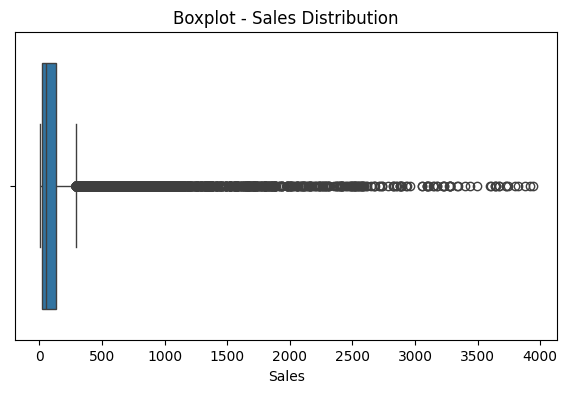

In [145]:
plt.figure(figsize=(7,4))
sns.boxplot(data=time_analysis_df, x='Sales')
plt.xlabel('Sales')
plt.title(f'Boxplot - Sales Distribution');


In [146]:
time_analysis_df.head(4)

,Row ID,Order ID,Customer ID,Segment,City,State,Country,Country latitude,Country longitude,Region,...,Sales,Discount,Profit,year,month,week,hour,day,day_str,year_month
Order Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,46682,IZ-2012-LW699061-40911,LW-699061,Corporate,Mosul,Ninawa,Iraq,33.223191,43.679291,Western Asia,...,600,0.0,300.0,2020,1,1,0,4,Fri,2020_01
2020-01-04,10124,US-2012-BT1130518-40912,BT-1130518,Self-Employed,Pilar,Alagoas,Brazil,-14.235004,-51.925280,South America,...,40,0.6,-4.0,2020,1,1,0,5,Sat,2020_01
2020-01-04,9067,MX-2012-AW1093031-40912,AW-1093031,Self-Employed,Santiago de Cuba,Santiago de Cuba,Cuba,21.521757,-77.781167,Caribbean,...,151,0.0,75.5,2020,1,1,0,5,Sat,2020_01
2020-01-04,130,MX-2012-BT1130531-40912,BT-1130531,Self-Employed,Manzanillo,Granma,Cuba,21.521757,-77.781167,Caribbean,...,40,0.0,20.0,2020,1,1,0,5,Sat,2020_01


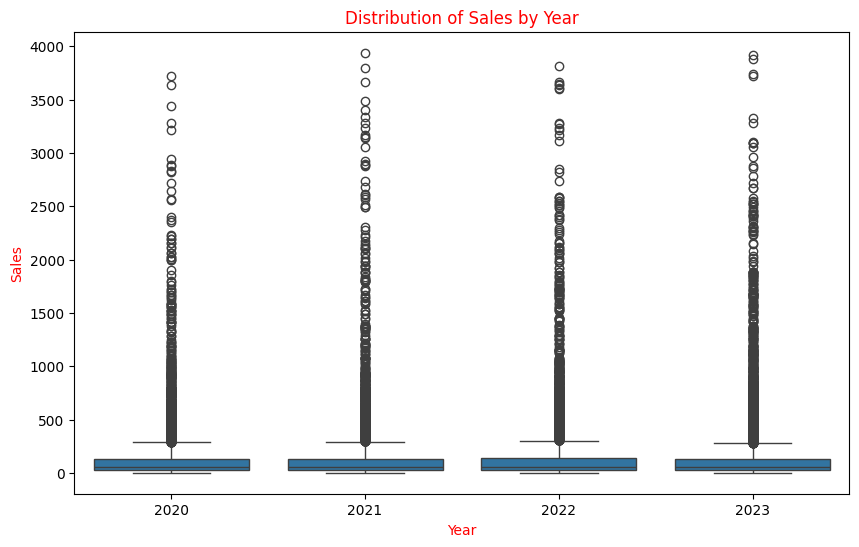

In [152]:
# Sorting the DataFrame by day of the week
df_plot = time_analysis_df[['year', 'Sales']].sort_values(by='year')

# Plotting boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='Sales', data=df_plot)
plt.title('Distribution of Sales by Year', color ='red')
plt.xlabel('Year', color ='red')
plt.ylabel('Sales', color='red')
plt.show()

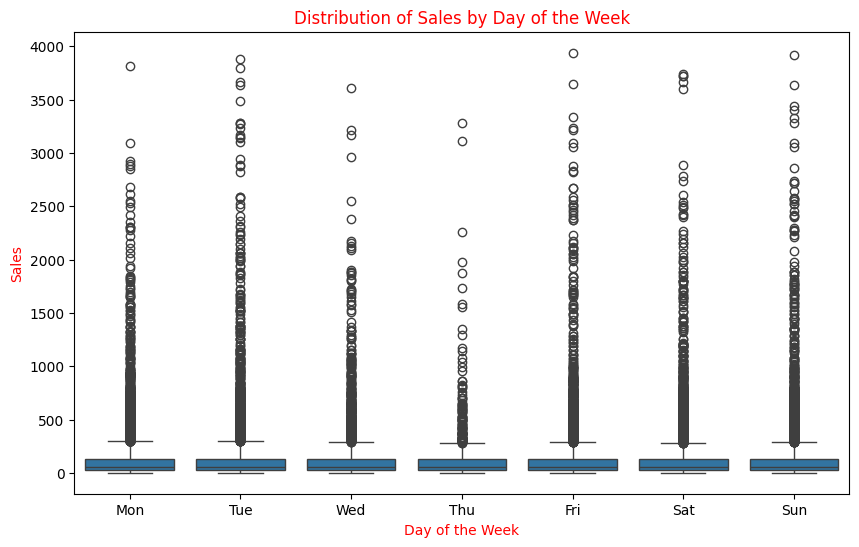

In [149]:
# Sorting the DataFrame by day of the week
df_plot = time_analysis_df[['day_str', 'day', 'Sales']].sort_values(by='day')

# Plotting boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_str', y='Sales', data=df_plot)
plt.title('Distribution of Sales by Day of the Week', color ='red')
plt.xlabel('Day of the Week', color ='red')
plt.ylabel('Sales', color='red')
plt.show()